In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [1]:
"""
@author: sebastianveum
"""

'\n@author: sebastianveum\n'

In [30]:

# Using same data as the file "Excel mapped HL procedure"
def main():
    
    
    optimizer = PortfolioOptimizer()

    returns, stdv, corr_matrix, cov_matrix = optimizer.get_portfolio_inputs()
    print(f"{'Portfolio Input Values:':>50}")
    print("{0:^15s}{1:^15s}{2:^25s}{3:^25s}".format("Returns", "Volatility", "Correlation Matrix", "Covariance Matrix"))

# Print the values
    for i in range(optimizer.portfolio_size):
        return_str = "{:.4f}".format(returns[i])
        volatility_str = "{:.4f}".format(stdv[i])
        corr_matrix_str = ', '.join(["{:.4f}".format(val) for val in corr_matrix[i]])
        cov_matrix_str = ', '.join(["{:.4f}".format(val) for val in cov_matrix[i]])
        
        print("{0:^15s}{1:^15s}{2:^25s}{3:^25s}".format(return_str, volatility_str, corr_matrix_str, cov_matrix_str)) # Might get ugly with greater portfolio size -> It's only used for jupyter


    print('\n'*2)
    
    
    # Showing values generated in def calculate_intermediate_quantities()
    variable_names=["A", "B", "C", "D", "G", "H"]

    variable_values = optimizer.calculate_intermediate_quantities()
    print("{0:^5s}{1:<12s}{2:>6s}".format("No#", "Variable", "Result"))
    idx = 1
    for var_name, value in zip(variable_names, variable_values):
        if isinstance(value, np.ndarray):
            for sub_value in value:
                print("{0:^5d}{1:<12s}{2:>6.4f}".format(idx, var_name, sub_value))
                idx += 1
        else:
            print("{0:^5d}{1:<12s}{2:>6.4f}".format(idx, var_name, value))
            idx += 1

    last_value = variable_values[-1]
    second_last_value = variable_values[-2]

    if isinstance(last_value, np.ndarray):
        last_value = np.sum(last_value) 
    if isinstance(second_last_value, np.ndarray):
        second_last_value = np.sum(second_last_value)  

    sum_last_two = second_last_value + last_value
    print("{0:^5d}{1:<12s}{2:>6.1f}".format(9, 'G+H', sum_last_two))


    print('\n' * 2)
    
    # Showig the 10 outputs of def calculate_mean_variance_efficient_frontier() --> remove 10 from the for loop to print all values.

    _, mean_var_portfolios = optimizer.calculate_mean_variance_efficient_frontier()
    
    # Print header
    print("{0:^15s}{1:^15s}{2:^15s}{3:^15s}{4:^15s}".format("Target return", "Return", "Volatility", "Sharpe Ratio", "Utility"))

    if mean_var_portfolios:
        for idx in range(0, len(mean_var_portfolios),10):
            if idx < len(mean_var_portfolios):  # Ensure index is within range
                portfolio_metrics = mean_var_portfolios[idx]              
                if len(portfolio_metrics) >= 3:
                    target_return=idx/100
                    portfolio_return = portfolio_metrics[0]
                    portfolio_volatility = portfolio_metrics[1]
                    sharpe_ratio = portfolio_metrics[2]
                    utility = portfolio_metrics[3]  
                    print("{0:^15s}{1:^15.4f}{2:^15.4f}{3:^15.4f}{4:^15.4f}".format("{0:.0%}".format(target_return), portfolio_return, portfolio_volatility, sharpe_ratio, utility))
                else:
                    print(f"Portfolio metrics at index {idx} does not have enough elements: {portfolio_metrics}")
            else:
                break  # Exit loop if index exceeds range of mean_var_portfolios

    print('\n'*2)
    
    # Writes to excel and returns the dataframe for usage in the print function
    optimizer.write_to_excel()
    
    # prints requested values
    optimizer.print_values()
    
     # Plots the efficient frontier with the max sharpe and min var portfolios     
    optimizer.plot_efficient_frontier()
    
    print('\n'*2)
    



                           Portfolio Input Values:
    Returns      Volatility      Correlation Matrix        Covariance Matrix    
    0.1934         0.3025          1.0000, 0.3500           0.0915, 0.0232      
    0.1575         0.2190          0.3500, 1.0000           0.0232, 0.0480      



 No# Variable    Result
  1  A           4.0382
  2  B           0.6884
  3  C           24.1733
  4  D           0.3347
  5  G           -4.3872
  6  G           5.3872
  7  H           27.8552
  8  H           -27.8552
  9  G+H            1.0



 Target return     Return       Volatility    Sharpe Ratio      Utility    
      0%           0.1671         0.2034         0.6001         0.1050     
      10%          0.1603         0.2112         0.5461         0.0934     
      20%          0.1736         0.2110         0.6098         0.1069     
      30%          0.2069         0.3953         0.4096         -0.0275    
      40%          0.2602         0.8176         0.2632         -0.7425    

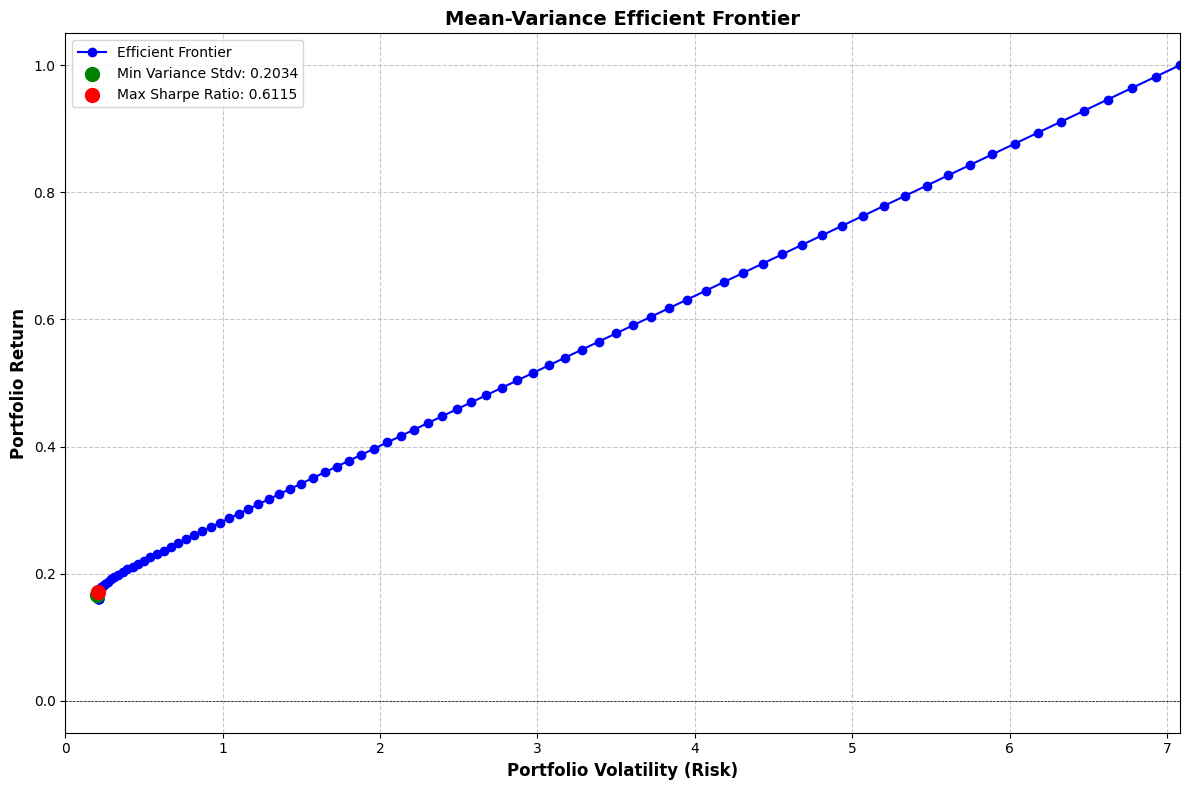

In [31]:

main()

In [ ]:
"""This version is purely made to show all data points"""

In [19]:
class PortfolioOptimizer:
    def __init__(self, expected_return=[0.1934,0.1575], volatility=[0.3025,0.219], corr_matrix=[[1,0.35],[0.35,1]], risk_free_rate= 0.045, portfolio_size=2, risk_aversion=3):
        """
        Initialize the PortfolioOptimizer instance.

        Parameters:
        - expected_return: list/array of expected returns for each security
        - volatility: list/array of volatilities for each security
        - corr_matrix: correlation matrix between securities
        - risk_free_rate: risk-free rate
        - portfolio_size: number of securities
        - risk_aversion: risk aversion parameter for utility calculation
        """

        self.expected_return = expected_return
        self.risk_free_rate = risk_free_rate
        self.portfolio_size = portfolio_size
        self.risk_aversion = risk_aversion
        self.dataframe=None

        self.returns = list(expected_return)
        self.corr_matrix = list(corr_matrix)
        self.stdv = list(volatility)

        # Initialize the covariance matrix with zeros
        self.cov_matrix = [[0.0 for _ in range(len(self.stdv))] for _ in range(len(self.stdv))]

        # Calculate the covariance matrix using nested loops
        for i in range(len(self.stdv)):
            for j in range(len(self.stdv)):
                self.cov_matrix[i][j] = self.stdv[i] * self.stdv[j] * self.corr_matrix[i][j]
    
        self.inv_cov_matrix = np.linalg.inv(self.cov_matrix)
        _,_,self.C,_, self.G, self.H=self.calculate_intermediate_quantities()

    
    def get_portfolio_inputs(self):
        return self.returns, self.stdv,self.corr_matrix,self.cov_matrix


    def compute_covariance_matrix(self):
        cov_matrix = self.dataset.drop(columns=['Date']).cov() * 12
        return cov_matrix

    def calculate_intermediate_quantities(self):
        # Calculates all variables from HL model
        u = np.ones(self.portfolio_size)
        inv_cov_matrix = self.inv_cov_matrix
        A = sum([sum(u[i] * self.returns[j] * inv_cov_matrix[i, j] for i in range(self.portfolio_size)) for j in range(self.portfolio_size)])
        B = sum([sum(self.returns[i] * self.returns[j] * inv_cov_matrix[i, j] for i in range(self.portfolio_size)) for j in range(self.portfolio_size)])
        C = sum([sum(u[i] * u[j] * inv_cov_matrix[i, j] for i in range(self.portfolio_size)) for j in range(self.portfolio_size)])
        M = np.dot(np.ones(self.portfolio_size), self.inv_cov_matrix)
        L = self.returns @ inv_cov_matrix
        D = B * C - A ** 2
        LA = np.dot(L, A)  # Vector L multiplied by matrix A
        MB = np.dot(M, B)  # Vector M multiplied by matrix B
        
        G = (1/D) * (MB - LA)
        
        LB = L * C  # Vector L multiplied by matrix B
        MA = M * A  # Vector M multiplied by matrix A

        H = (LB - MA) / D
        
        return A, B, C, D, G, H
    
    # Calculate all relevant values for a portfolio
    def calculate_portfolio_metrics(self, weights):
        portfolio_return = np.sum(weights * self.returns)
        portfolio_variance = np.dot(weights.T, np.dot(self.cov_matrix, weights))
        portfolio_risk = np.sqrt(portfolio_variance)
        excess_return = portfolio_return - self.risk_free_rate
        sharpe_ratio = excess_return / portfolio_risk
        utility = portfolio_return - 0.5 * self.risk_aversion * portfolio_variance
        return portfolio_return, portfolio_risk, sharpe_ratio, utility

    # Calculate minimum variance weights
    def calculate_minimum_variance_portfolio(self):
        min_var_weights = np.dot(self.inv_cov_matrix, np.ones(self.portfolio_size)) /self.C
        return min_var_weights

    # Calculate optimal variance weights
    def calculate_optimum_variance_portfolio(self, target_return):
        weights = self.G+(target_return*self.H)
        return weights

    def calculate_mean_variance_efficient_frontier(self):
        """
        Calculate and returns one list of lists with all weights for the mean-variance optimal portfolio on target return.
        Returns the efficient frotnier portfolio_return, portfolio_risk, sharpe_ratio, utility for mean-variance optimal portfolio
        """
        min_var_weights = self.calculate_minimum_variance_portfolio()
        frontier_weights = []
        for target_return in np.linspace(0, 1, 101):
            opt_var_weights = self.calculate_optimum_variance_portfolio(target_return)
            weights = (1 - target_return) * min_var_weights + target_return * opt_var_weights
            frontier_weights.append(weights)
        frontier_metrics = [self.calculate_portfolio_metrics(w) for w in frontier_weights]
        return frontier_weights, frontier_metrics

    def plot_efficient_frontier(self):
        """
        Plot the mean-variance efficient frontier along with the min variance point
        and the max Sharpe ratio point.
        """
        _, frontier_metrics = self.calculate_mean_variance_efficient_frontier()
        frontier_risks = [metric[1] for metric in frontier_metrics]
        frontier_returns = [metric[0] for metric in frontier_metrics]
        sharpe_ratios = [metric[2] for metric in frontier_metrics]

        # Find index of the lowest standard deviation (min variance point)
        min_var_idx = np.argmin(frontier_risks)
        min_var_point = frontier_metrics[min_var_idx]
        
        # Find index of the greatest Sharpe ratio (max Sharpe ratio point)
        max_sharpe_idx = np.argmax(sharpe_ratios)
        max_sharpe_point = frontier_metrics[max_sharpe_idx]

        # Plotting the efficient frontier and key points
        plt.figure(figsize=(12, 8))

        plt.plot(frontier_risks, frontier_returns, 'b-o', label='Efficient Frontier')

        # Highlighting the min variance point
        plt.scatter(min_var_point[1], min_var_point[0], color='green', marker='o', s=100, 
                zorder=5, label=f'Min Variance Stdv: {min_var_point[1]:.4f}')

        # Highlighting the max Sharpe ratio point
        plt.scatter(max_sharpe_point[1], max_sharpe_point[0], color='red', marker='o', s=100, 
                    zorder=5, label=f'Max Sharpe Ratio: {max_sharpe_point[2]:.4f}')

        # Additional plot settings for aesthetics
        plt.xlabel('Portfolio Volatility (Risk)', fontsize=12, fontweight='bold')
        plt.ylabel('Portfolio Return', fontsize=12, fontweight='bold')
        plt.title('Mean-Variance Efficient Frontier', fontsize=14, fontweight='bold')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
        plt.xlim(0.0, max(frontier_risks))

        # Show the plot
        plt.tight_layout()  # Ensures labels do not overlap
        plt.show()

    def write_to_excel(self, output_file='230023476PortfolioProblem.xlsx'):
        
        frontier_weights, frontier_metrics = self.calculate_mean_variance_efficient_frontier()
        # Check if dataset exists or if the user input is the dataset for the weights columns
        if hasattr(self, 'ds'): 
            weight_columns = [f'w_{col}' for col in self.dataset.columns[1:]]
        else:
            weight_columns = [f'w{i+1}' for i in range(self.portfolio_size)]
        
        data = {
            'Return': [metric[0] for metric in frontier_metrics],
            'Volatility': [metric[1] for metric in frontier_metrics],
            'Utility': [metric[3] for metric in frontier_metrics],
            'Sharpe Ratio': [metric[2] for metric in frontier_metrics]
        }

        # Make columns for weights and round all data to 4 decimals
        for i, col in enumerate(weight_columns):
            data[col] = [w[i] for w in frontier_weights]

        df = pd.DataFrame(data)
        df.sort_values(by='Return', inplace=True)
        numeric_columns = ['Return', 'Volatility', 'Utility', 'Sharpe Ratio'] + weight_columns
        df[numeric_columns] = df[numeric_columns].round(4)
        
        # Write to excel sheet and replace existing output sheet if it exists
        with pd.ExcelWriter(output_file, mode='a', engine="openpyxl",if_sheet_exists="replace") as writer:
            df.to_excel(writer, sheet_name='output', index=False)
            workbook = writer.book
            worksheet = workbook['output']
            
            # Regular nested for loop as requested from assignment
            for column_cells in worksheet.columns:
                max_length = 0
                column = column_cells[0].column_letter  # Get the column name
                for cell in column_cells:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(cell.value)
                    except:
                        pass
                adjusted_width = (max_length + 2) * 1.2  # Adjust the width for autofitting
                worksheet.column_dimensions[column].width = adjusted_width
        self.dataframe=df
    
    def print_values(self):
        
        print('\n' * 2)
        # Print maximum Sharpe Ratio
        max_sharpe_idx = self.dataframe['Sharpe Ratio'].idxmax()
        max_sharpe_return = self.dataframe.loc[max_sharpe_idx, 'Return']
        max_sharpe_volatility = self.dataframe.loc[max_sharpe_idx, 'Volatility']
        max_sharpe_value = self.dataframe.loc[max_sharpe_idx, 'Sharpe Ratio']
        max_sharpe_utility = self.dataframe.loc[max_sharpe_idx, 'Utility']
        
        print(f"{'Maximum Sharpe Ratio Portfolio:':^60}")
        print(f"{'Return':^15} {'Volatility':^15} {'Sharpe Ratio':^15} {'Utility':^15}")
        print(f"{max_sharpe_return:^15.4f} {max_sharpe_volatility:^15.4f} {max_sharpe_value:^15.4f} {max_sharpe_utility:^15.4f}")
        
        print('\n' * 2)
        
        # Print maximum Utility
        max_utility_idx = self.dataframe['Utility'].idxmax()
        max_utility_return = self.dataframe.loc[max_utility_idx, 'Return']
        max_utility_volatility = self.dataframe.loc[max_utility_idx, 'Volatility']
        max_utility_sharpe=self.dataframe.loc[max_utility_idx, 'Sharpe Ratio']
        max_utility_value = self.dataframe.loc[max_utility_idx, 'Utility']
        print(f"{'Maximum Utility Portfolio:':^60}")
        print(f"{'Return':^15} {'Volatility':^15} {'Sharpe Ratio':^15} {'Utility':^15}")
        print(f"{max_utility_return:^15.4f} {max_utility_volatility:^15.4f} {max_utility_sharpe:^15.4f} {max_utility_value:^15.4f}")
        
        print('\n' * 2)    
            
        # Print minimum volatility
        min_volatility_idx = self.dataframe['Volatility'].idxmin()
        min_volatility_return = self.dataframe.loc[min_volatility_idx, 'Return']
        min_volatility_volatility = self.dataframe.loc[min_volatility_idx, 'Volatility']
        min_volatility_sharpe = self.dataframe.loc[min_volatility_idx, 'Sharpe Ratio']
        min_volatility_utility = self.dataframe.loc[min_volatility_idx, 'Utility']
        print(f"{'Minimum Volatility Portfolio:':^60}")
        print(f"{'Return':^15} {'Volatility':^15} {'Sharpe Ratio':^15} {'Utility':^15}")
        print(f"{min_volatility_return:^15.4f} {min_volatility_volatility:^15.4f} {min_volatility_sharpe:^15.4f} {min_volatility_utility:^15.4f}")

        print('\n' * 2) 
